Loading file


In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv("hotel_booking.csv", low_memory=False)
print("shape:", df.shape)

shape: (119390, 36)


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
print(df.isna().sum().sort_values(ascending=False).head(20))

company                           112593
agent                              16340
country                              488
children                               4
hotel                                  0
booking_changes                        0
deposit_type                           0
days_in_waiting_list                   0
customer_type                          0
adr                                    0
reserved_room_type                     0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
reservation_status_date                0
name                                   0
email                                  0
phone-number                           0
assigned_room_type                     0
previous_bookings_not_canceled         0
dtype: int64


fixing data type

In [6]:
df['children'] = df['children'].fillna(0).astype(int)
df['agent'] = df['agent'].fillna(0).astype(int)
df['company'] = df['company'].fillna(0).astype(int)
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], format='%Y-%m-%d', errors='coerce')
df.rename(columns={'phone-number': 'phone_number'}, inplace=True)

handling missing values

In [7]:
df['country'] = df['country'].fillna("Unknown")
#rest we have handled by fixing data types

outlier detection

In [8]:
cols_with_outliers = [
    'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 
    'adults', 'children', 'babies', 'previous_cancellations', 
    'previous_bookings_not_canceled', 'booking_changes', 'agent', 
    'company', 'days_in_waiting_list', 'adr', 
    'required_car_parking_spaces', 'total_of_special_requests'
]
outlier_summary = {}

for col in cols_with_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    
    outlier_summary[col] = {
        "Total Rows": df[col].shape[0],
        "Outlier Count": outliers.shape[0],
        "Outlier %": round(outliers.shape[0] / df[col].shape[0] * 100, 2),
        "Min Value": df[col].min(),
        "Max Value": df[col].max(),
        "Lower Bound": round(lower,2),
        "Upper Bound": round(upper,2)
    }

outlier_report = pd.DataFrame(outlier_summary).T
print(outlier_report)


                                Total Rows  Outlier Count  Outlier %  \
lead_time                         119390.0         3005.0       2.52   
stays_in_weekend_nights           119390.0          265.0       0.22   
stays_in_week_nights              119390.0         3354.0       2.81   
adults                            119390.0        29710.0      24.88   
children                          119390.0         8590.0       7.19   
babies                            119390.0          917.0       0.77   
previous_cancellations            119390.0         6484.0       5.43   
previous_bookings_not_canceled    119390.0         3620.0       3.03   
booking_changes                   119390.0        18076.0      15.14   
agent                             119390.0         1254.0       1.05   
company                           119390.0         6797.0       5.69   
days_in_waiting_list              119390.0         3698.0       3.10   
adr                               119390.0         3793.0       

lead time--> max=737 days- no one books the hotel in 2yrs advance-->(Capping) max 1yr


In [9]:
df["lead_time"] = np.where(df["lead_time"] > 365, 365, df["lead_time"])


stays_in_week_nights / weekend nights (~3%)---Long stays occur (business + tourism)

adult can't be more than 4 in a single room. (not allowed)

In [10]:
df["adults"] = np.where(df["adults"] > 4, 4, df["adults"])

children & babies can't be more than 3 & 2 respectively.

In [11]:
df["children"] = np.where(df["children"] > 3, 3, df["children"])
df["babies"] = np.where(df["babies"] > 2, 2, df["babies"])

we can keep previous_cancellations, previous_bookings_not_canceled & booking_changes as it is because it shows customer behaviour

no need to handle agent & company as it is Ids.

days_in_waiting_list can be max 3 months.

In [12]:
df["days_in_waiting_list"] = np.where(df["days_in_waiting_list"] > 90, 90, df["days_in_waiting_list"])

adr(Average Daily Rate) --> max = 500


In [13]:
df["adr"] = np.where(df["adr"] > 500, 500, df["adr"])
df["adr"] = np.where(df["adr"] < 0, 0, df["adr"])

normally, tourist can require max 2 parking space.

In [14]:
df["required_car_parking_spaces"] = np.where(df["required_car_parking_spaces"] > 2, 2, df["required_car_parking_spaces"])

special request can be 5. keep it.

Feature Engineering

In [15]:
df["total_guests"] = df["adults"] + df["children"] + df["babies"]
df["total_stay"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]
df["lead_time_cat"] = pd.cut(df["lead_time"], 
                             bins=[0, 30, 90, 180, 365], 
                             labels=["Short", "Medium", "Long", "Very Long"])
df["high_canceller"] = np.where(df["previous_cancellations"] > 3, 1, 0)
df["revenue"] = df["adr"] * df["total_stay"] * df["total_guests"]
df["last_minute"] = np.where(df["lead_time"] < 7, 1, 0)
df["traveller_type"] = np.where(df["total_guests"] > 2, "Family", "Solo/Pair")


In [16]:
room_order = ["A", "B", "C", "D", "E", "F", "G"]
df["reserved_room_type"] = pd.Categorical(df["reserved_room_type"], categories=room_order, ordered=True)
df["assigned_room_type"] = pd.Categorical(df["assigned_room_type"], categories=room_order, ordered=True)

In [17]:
df["room_changed"] = np.where(
    df["reserved_room_type"] < df["assigned_room_type"], "upgraded",
    np.where(df["reserved_room_type"] > df["assigned_room_type"], "downgraded", "no_change")
)

In [18]:
print(df.columns.to_list())

['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date', 'name', 'email', 'phone_number', 'credit_card', 'total_guests', 'total_stay', 'lead_time_cat', 'high_canceller', 'revenue', 'last_minute', 'traveller_type', 'room_changed']


EDA

UNIVARIATE ANALYSIS

In [19]:
total_bookings = df.shape[0]
cancelled = df['is_canceled'].sum()
not_cancelled = total_bookings - cancelled

cancel_rate = (cancelled / total_bookings) * 100

print(f"Total Bookings       : {total_bookings}")
print(f"Cancelled Bookings   : {cancelled}")
print(f"Not Cancelled        : {not_cancelled}")
print(f"Cancellation Rate    : {cancel_rate:.2f}%")


Total Bookings       : 119390
Cancelled Bookings   : 44224
Not Cancelled        : 75166
Cancellation Rate    : 37.04%


1. ~37% bookings are canceled
2. Very high cancellation rate → directly impacts hotel revenue
3. Hotels should tighten advance booking refund rules or early deposit policy.

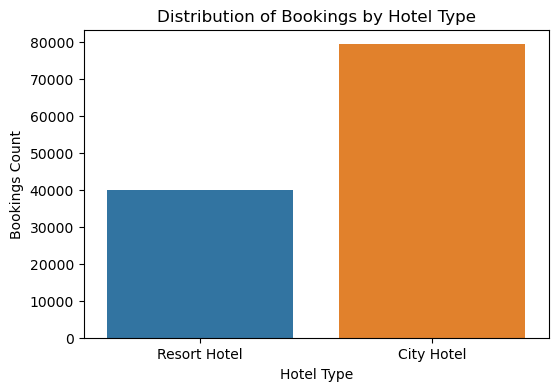

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x='hotel', data=df)
plt.title("Distribution of Bookings by Hotel Type")
plt.xlabel("Hotel Type")
plt.ylabel("Bookings Count")
plt.show()

1. City Hotel receives more bookings than Resort Hotel.
2. Indicates stronger demand in urban/business travel vs. vacation stays.

c:\Users\palak\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


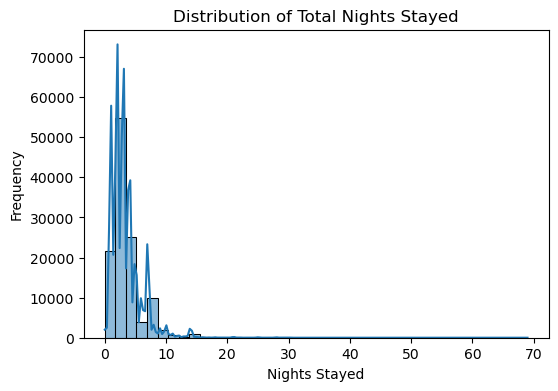

In [24]:
plt.figure(figsize=(6,4))
sns.histplot(df['total_stay'], bins=40, kde=True)
plt.title("Distribution of Total Nights Stayed")
plt.xlabel("Nights Stayed")
plt.ylabel("Frequency")
plt.show()

1. Most guests stay 1 to 4 nights → short-stay business / weekend tourism.
2. Very long stays are rare → revenue mostly rotates quickly

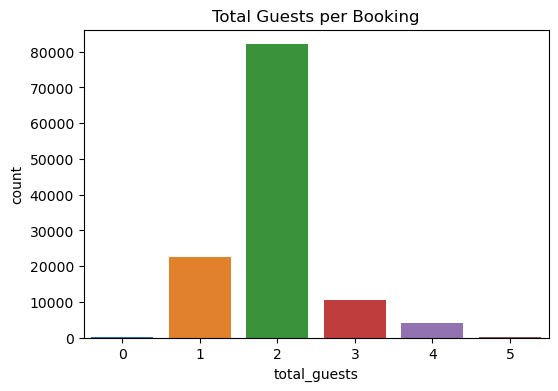

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(x='total_guests', data=df)
plt.title("Total Guests per Booking")
plt.show()

1. Most bookings are for 1–2 guests.
2. Rooms accommodating 3+ guests might be underused → pricing or marketing opportunity.

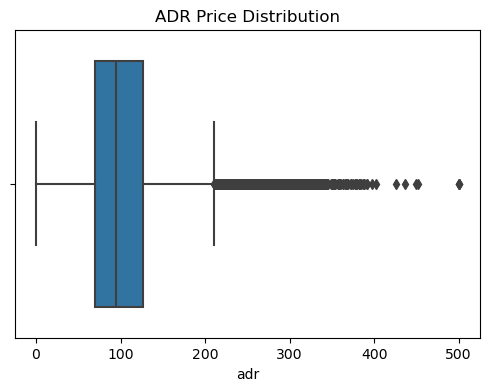

In [26]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['adr'])
plt.title("ADR Price Distribution")
plt.show()

Prices are skewed → Hotel has premium priced rooms but majority bookings happen at low–mid range.

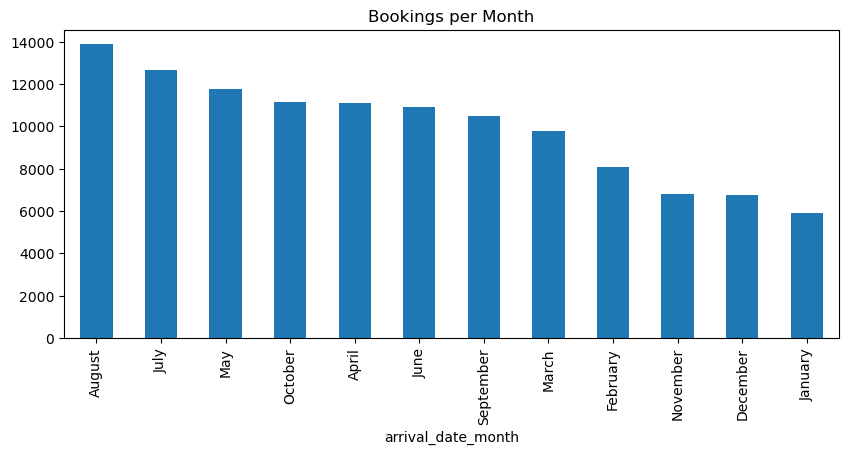

In [27]:
plt.figure(figsize=(10,4))
df['arrival_date_month'].value_counts().plot(kind='bar')
plt.title("Bookings per Month")
plt.show()

Clear seasonality → useful for dynamic pricing.

BIVARIATE ANALYSIS

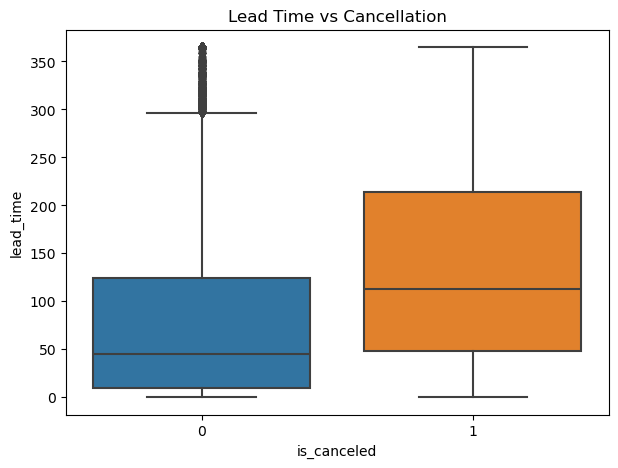

In [28]:
plt.figure(figsize=(7,5))
sns.boxplot(x='is_canceled', y='lead_time', data=df)
plt.title("Lead Time vs Cancellation")
plt.show()

1. Bookings done far in advance cancel more.
2. People who plan early change their plans / find better deals.
3. Action: Implement deposit or reminder strategy for long lead-time bookings.

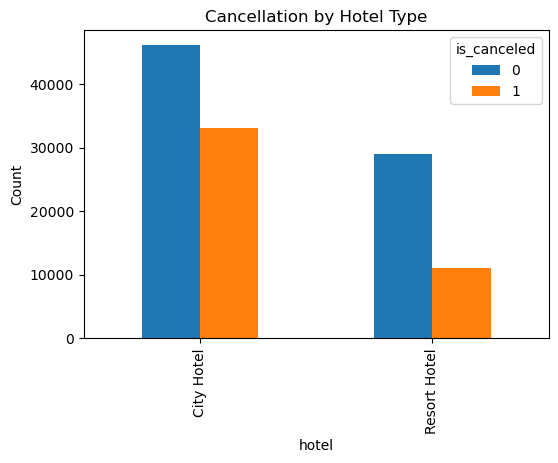

In [29]:
pd.crosstab(df['hotel'], df['is_canceled']).plot(kind='bar', figsize=(6,4))
plt.title("Cancellation by Hotel Type")
plt.ylabel("Count")
plt.show()

City Hotels have higher cancellations → business trips are more uncertain than vacation plans.

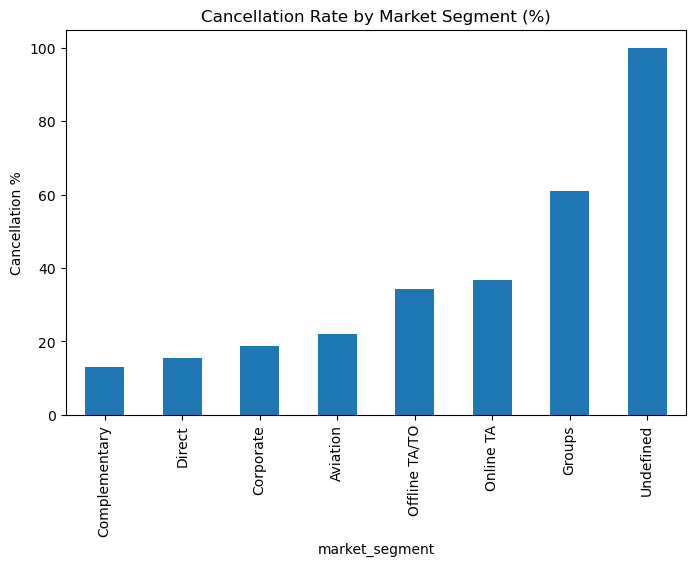

In [31]:
plt.figure(figsize=(8,5))
(df.groupby('market_segment')['is_canceled'].mean()*100).sort_values().plot(kind='bar')
plt.title("Cancellation Rate by Market Segment (%)")
plt.ylabel("Cancellation %")
plt.show()

Corporate bookings are most reliable.
OTA dependency → revenue instability risk.

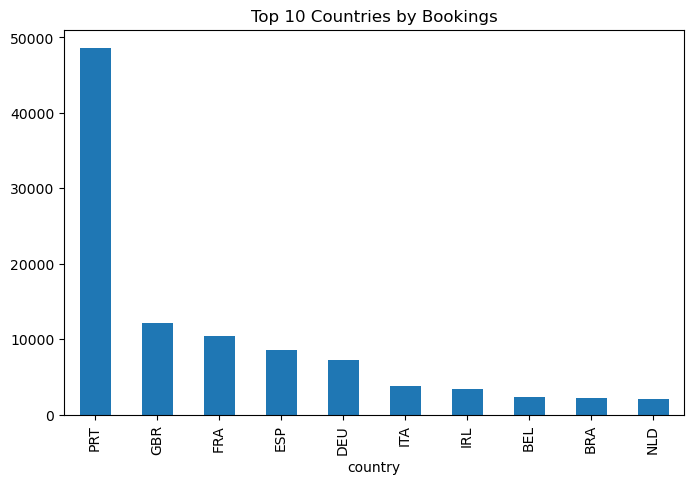

In [33]:
plt.figure(figsize=(8,5))
df['country'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Countries by Bookings")
plt.show()


Hotel gets significant international customers → Multi-language service & targeted promotions needed.

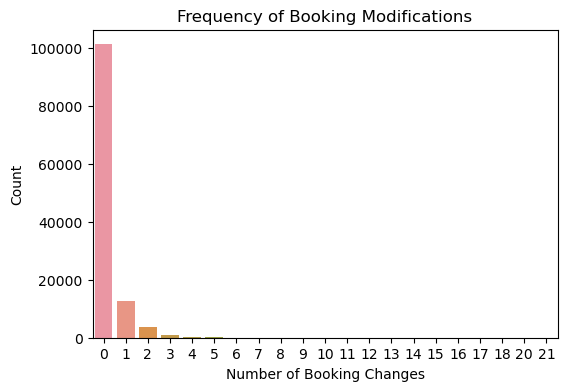

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(x='booking_changes', data=df)
plt.title("Frequency of Booking Modifications")
plt.xlabel("Number of Booking Changes")
plt.ylabel("Count")
plt.show()

~80–90% bookings have no changes → guests generally confirm and stick to their original plan.

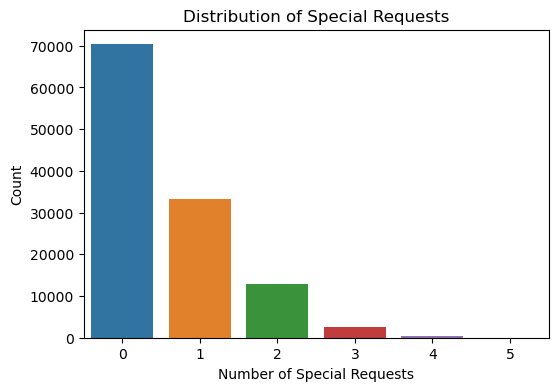

In [37]:
plt.figure(figsize=(6,4))
sns.countplot(x='total_of_special_requests', data=df)
plt.title("Distribution of Special Requests")
plt.xlabel("Number of Special Requests")
plt.ylabel("Count")
plt.show()

1. Majority of customers make no special requests → standard rooms are preferred.
2. Guests with higher special requests tend to care more about their stay → lower probability of cancellation

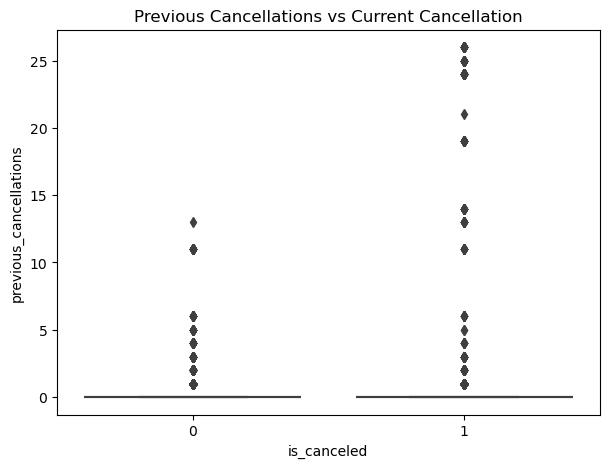

In [38]:
plt.figure(figsize=(7,5))
sns.boxplot(x='is_canceled', y='previous_cancellations', data=df)
plt.title("Previous Cancellations vs Current Cancellation")
plt.show()

1. Guests who have canceled before are more likely to cancel again.
2. This indicates a behavioral cancellation pattern → repeat cancellers are high-risk customers.
3. Hotels should flag such accounts & request upfront deposit.

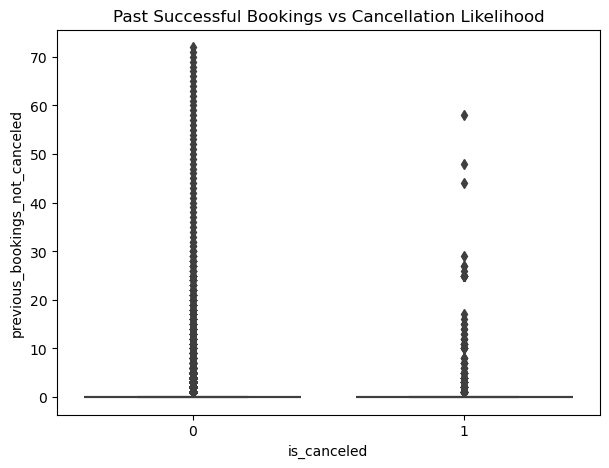

In [39]:
plt.figure(figsize=(7,5))
sns.boxplot(x='is_canceled', y='previous_bookings_not_canceled', data=df)
plt.title("Past Successful Bookings vs Cancellation Likelihood")
plt.show()

1. Guests who reliably completed previous bookings rarely cancel.
2. This is a loyalty signal — these customers should be rewarded (discounts, perks).

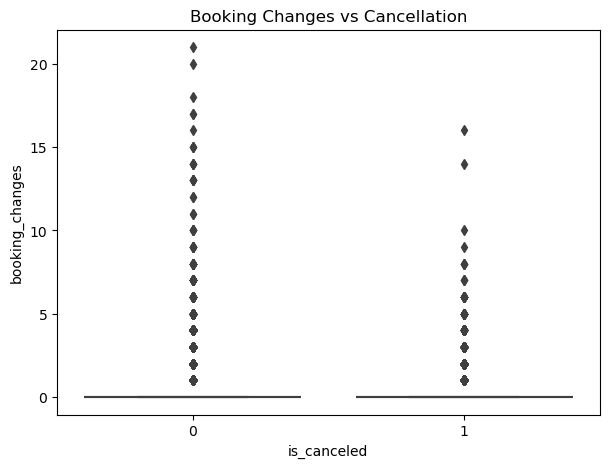

In [40]:
plt.figure(figsize=(7,5))
sns.boxplot(x='is_canceled', y='booking_changes', data=df)
plt.title("Booking Changes vs Cancellation")
plt.show()

1. Guests who frequently modify bookings are slightly more likely to cancel.
2. Indicates uncertain travel plans → hotel should follow up with reminders for such guests.

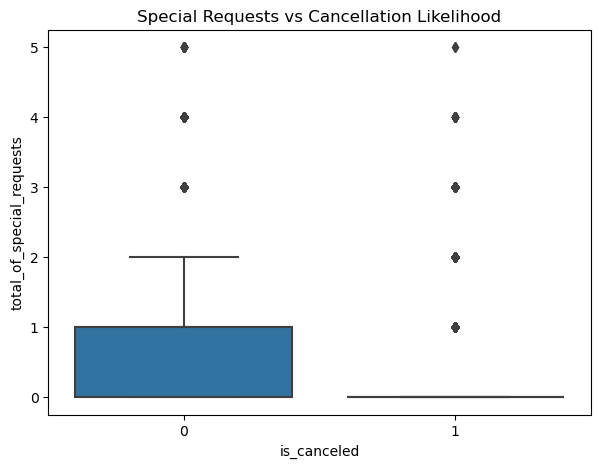

In [42]:
plt.figure(figsize=(7,5))
sns.boxplot(x='is_canceled', y='total_of_special_requests', data=df)
plt.title("Special Requests vs Cancellation Likelihood")
plt.show()

1. More special requests → lower cancellation rate.
2. These guests are serious about their stay → treat as high-value customers.

c:\Users\palak\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


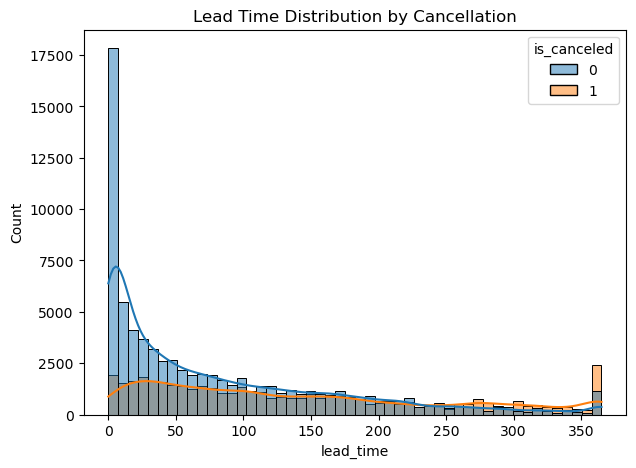

In [43]:
plt.figure(figsize=(7,5))
sns.histplot(data=df, x='lead_time', hue='is_canceled', bins=50, kde=True)
plt.title("Lead Time Distribution by Cancellation")
plt.show()

1. Last-minute bookings rarely cancel.
2. Because guests book when plans are already confirmed.

Final Insights

In [ ]:
"""Booking Behavior & Guest Profile

Most stays range from 1-4 nights, indicating hotels mainly handle short leisure and business trips.

Majority of bookings are for 1-2 guests, which suggests standard rooms fulfill most accommodation requirements.

Most guests do not place special requests, meaning standard room amenities generally meet expectations.

Cancellation Patterns & Risk Indicators

Long lead-time bookings have a higher cancellation rate.
Guests who book far in advance often revise or cancel plans → these bookings are high-risk.

Guests who canceled previously are more likely to cancel again.
Cancellation behavior tends to repeat, suggesting a behavioral pattern rather than randomness.

Guests with a history of honoring past reservations show low cancellation probability.
These are loyal and reliable customers who should be rewarded with loyalty benefits or personalized offers.

Frequent booking modifications are associated with slightly increased cancellations.
These customers have uncertain travel plans, and require follow-up reminders or flexible change policies.

Special Requests & Customer Commitment

Guests with more special requests are less likely to cancel.
These bookings are intentional and likely tied to specific events or planned stays.
These guests should be treated as high-value and given priority support.

Timing of Bookings

Last-minute bookings generally have one of the lowest cancellation rates.
These reservations occur when travel plans are already confirmed, and thus represent low cancellation risk."""

'Booking Behavior & Guest Profile\n\nMost stays range from 1–4 nights, indicating hotels mainly handle short leisure and business trips.\n\nMajority of bookings are for 1–2 guests, which suggests standard rooms fulfill most accommodation requirements.\n\nMost guests do not place special requests, meaning standard room amenities generally meet expectations.\n\nCancellation Patterns & Risk Indicators\n\nLong lead-time bookings have a higher cancellation rate.\nGuests who book far in advance often revise or cancel plans → these bookings are high-risk.\n\nGuests who canceled previously are more likely to cancel again.\nCancellation behavior tends to repeat, suggesting a behavioral pattern rather than randomness.\n\nGuests with a history of honoring past reservations show low cancellation probability.\nThese are loyal and reliable customers who should be rewarded with loyalty benefits or personalized offers.\n\nFrequent booking modifications are associated with slightly increased cancellati

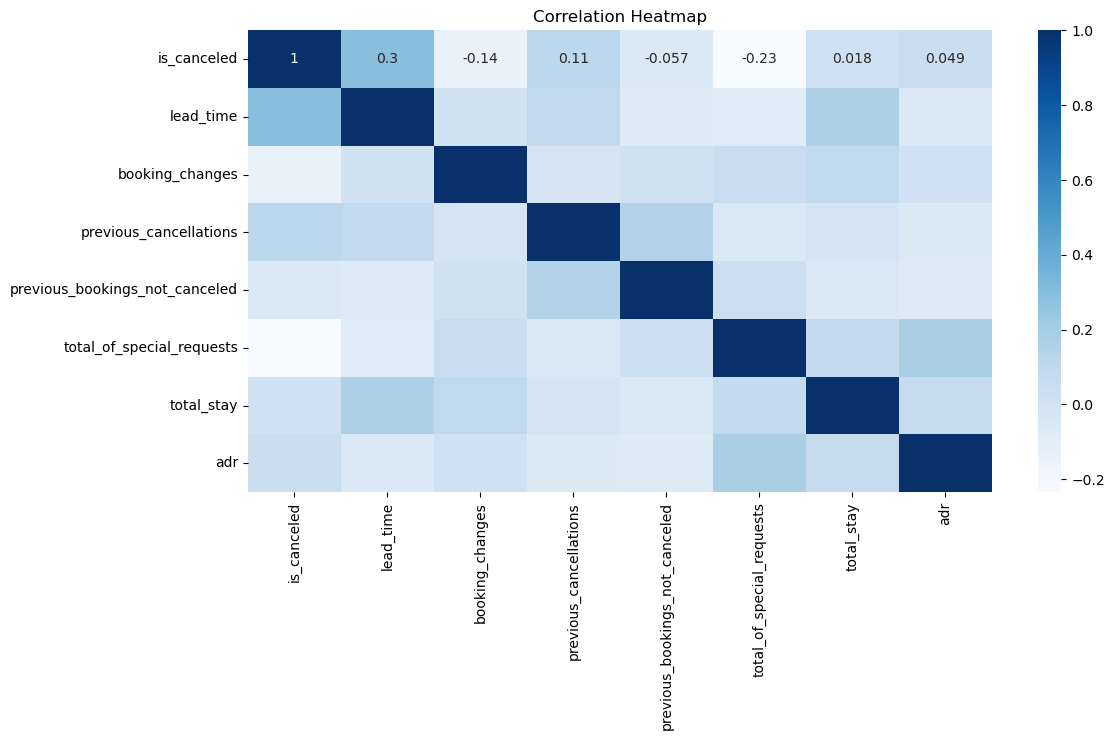

In [46]:
plt.figure(figsize=(12,6))
corr = df[['is_canceled','lead_time','booking_changes','previous_cancellations','previous_bookings_not_canceled','total_of_special_requests','total_stay','adr']].corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()

1. lead_time is positively correlated with cancellation → earlier bookings cancel more.
2. previous_cancellations also strongly correlates → repeat cancellation behavior.
3. special_requests has negative correlation → more requests → less cancellation.

In [48]:
final_df = df[['hotel','is_canceled','lead_time','arrival_date_year','arrival_date_month',
               'arrival_date_week_number','arrival_date_day_of_month',
               'stays_in_weekend_nights','stays_in_week_nights','total_stay',
               'adults','children','babies','total_guests',
               'meal','country','market_segment',
               'previous_cancellations','previous_bookings_not_canceled',
               'booking_changes','total_of_special_requests','adr','revenue']]


In [49]:
final_df.to_csv("hotel_final_cleaned.csv", index=False)